## Comparing between tools (BT) and within tools (WT) variabilities

In this project, we aim to study how the numerical variability is in comparison with the tool variability
and how an fMRI annalysis is numerically stable.
For this purpose, we replicate the fMRI analysis used in the paper of [Bowring et al.](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.24603) with different tools using the MCA perturbation method ([fuzzy libmath](https://github.com/big-data-lab-team/MCA-libmath)), and then compare the variability between tool changes and the MCA-based model.



## Data processing

- In this work, we replicate [the fMRI analysis (ds000001)](https://github.com/NISOx-BDI/Software_Comparison) across three of the most popular software packages in neuroimaging including FSL, AFNI, and SPM. There are three functional fMRI studies with the publicly available data repository, including:
  - Balloon analog risk task on 16 subjects (ds000001)

- We build docker images containing requisites for running the fMRI analyses such as processing tools (FSL, AFNI, SPM) and their dependencies, and the libmath fuzzy environment for applying MCA perturbations.


- We produce different result samples by running the fMRI preprocessing steps in each study in two conditions, with and without instrumentations, using the three software packages.


- We then compare (un)thresholded T-statistics of subject- and group-level activation maps statistically by the metrics of standard deviations and Dice coefficients in each condition.


### Code section

In [1]:
import os
import nilearn
from nilearn import plotting
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os.path as op
import matplotlib
from PIL import Image
from nibabel.processing import resample_from_to


/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Maps of standard deviations
Group-level and subject-level of thresholded and unthresholded t-statistics

In [2]:
# I did some hacking to have the plot sizes in plot_img as in plot_stat_map
# vim venv3/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py
# line 306
# I did some colorbar hacking in nilearn display
# vim venv3/lib/python3.8/site-packages/nilearn/plotting/displays.py
# nb_ticks = 5
# self._colorbar_ax.yaxis.tick_right()

#mni_ = nilearn.datasets.load_mni152_template()
z_coords = [-32, -18, 0, 12, 24, 40, 58] #[-30, -16, 0, 20, 36, 50, 64]
cut_coord_ = [4,15,0] #[0,-24,12]
clbar = False
max_ratio = 10
max_diff = 5

In [3]:

def make_z_ortho_plots(path_, pre_, ext_, out_, cmap_, cut_coord_, z_coords, vmax_, clbar):
    fig = plt.figure(figsize=(15, 8))
    for pair_ in ["fsl-afni", "fsl-spm", "afni-spm"]:
        img_ = '{}{}{}-{}-std.nii.gz'.format(path_, pre_, pair_, ext_)
        if pre_ == 'btMwt-':
            img_ = '{}{}{}-{}.nii.gz'.format(path_, pre_, pair_, ext_)
            display1 = plotting.plot_img(img_, vmax=vmax_, vmin=-vmax_ , black_bg=True,
                                         display_mode='ortho', cut_coords=cut_coord_,
                                         colorbar=clbar, threshold=0, bg_img='MNI152TEMPLATE',
                                         #norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                         cmap=cmap_,  draw_cross=False)
            display2 = plotting.plot_img(img_, vmax=vmax_, vmin=-vmax_ , black_bg=False,
                                         display_mode='z', cut_coords=z_coords,
                                         colorbar=clbar, threshold=0, bg_img='MNI152TEMPLATE',
                                         #norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                         cmap=cmap_, draw_cross=False)

        else:
            display1 = plotting.plot_stat_map(img_,
                                             vmax=vmax_, black_bg=True,display_mode='ortho', colorbar=clbar,
                                             norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                             cmap=cmap_,cut_coords=cut_coord_, draw_cross=False)

            display2 = plotting.plot_stat_map(img_, vmax=vmax_, display_mode='z', cut_coords=z_coords,
                                             norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                             cmap=cmap_,colorbar=clbar, draw_cross=False)
        
        display1.savefig('{}{}-{}-ortho.png'.format(out_, pair_, ext_)) 
        display2.savefig('{}{}-{}-z.png'.format(out_, pair_, ext_)) 
        #display.title('Your title', size=30)
        #display.annotate(size=30)
    

def make_row_of_tools(path_, pre_, ext_, out_):
    fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(12, 24), gridspec_kw={'height_ratios': [2.6, 1]})
    plt.subplots_adjust(wspace=.05, top=0.2, hspace=0.0)
    for i, pair_ in enumerate(["fsl-spm", "fsl-afni", "afni-spm"]):
        img_z = '{}{}{}-{}-z.png'.format(path_, pre_, pair_, ext_)
        img_ortho = '{}{}{}-{}-ortho.png'.format(path_, pre_, pair_, ext_)
        img_z = Image.open(img_z)
        img_ortho = Image.open(img_ortho)
        
        #if title == True:
        #    ax[0][i].set_title(pair_.upper(), pad=20)
        ax[0][i].imshow(img_ortho)
        ax[0][i].axis('off')
        ax[1][i].imshow(img_z)
        ax[1][i].axis('off')

    plt.savefig(out_, bbox_inches='tight', format='png', dpi=600, facecolor='white', transparent=False)

    
def make_complete_fig(path_, pre_, ext_, out_, hspace_=0.0):
    fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(24, 16))
    plt.subplots_adjust(hspace=hspace_)
    for i, cond in enumerate(["bt", "wt", "btMwt"]):
        img_ = '{}{}{}-{}.png'.format(path_, pre_, cond, ext_)
        img_ = Image.open(img_)
        ax[i].imshow(img_)
        #ax[i].set_ylabel("BT variability")
        #plt.xticks([])
        #plt.yticks([])
        ax[i].axis('off')

    plt.savefig(out_, bbox_inches='tight', dpi=600, format='png', facecolor='white', transparent=False)


In [ ]:
##### Subject-level unthresholded
for i in range(1, 17):
    sbj = '%.2d' % i
    make_z_ortho_plots('./data/std/subject_level/sub-{}/sbj{}-'.format(sbj, sbj), '', 'unthresh',
                       './paper/figures/plots/sbj{}-'.format(sbj),
                       'hsv', cut_coord_, z_coords, 3, False)
    make_z_ortho_plots('./data/std/subject_level/sub-{}/sbj{}-'.format(sbj, sbj), 'fuzzy-', 'unthresh',
                       './paper/figures/plots/sbj{}-fuzzy-'.format(sbj),
                       'hsv', cut_coord_, z_coords, 3, False)
    make_z_ortho_plots('./data/std/subject_level/sub-{}/sbj{}-'.format(sbj, sbj), 'btMwt-', 'unthresh',
                       './paper/figures/plots/sbj{}-btMwt-'.format(sbj),
                       'seismic', cut_coord_, z_coords, max_diff, False)


######### Group-level unthresholded
make_z_ortho_plots('./data/std/', '', 'unthresh', './paper/figures/plots/',
                   'hsv', cut_coord_, z_coords, 3, clbar)
make_z_ortho_plots('./data/std/', 'fuzzy-', 'unthresh', './paper/figures/plots/fuzzy-',
                   'hsv', cut_coord_, z_coords, 3, clbar)
make_z_ortho_plots('./data/std/', 'btMwt-', 'unthresh', './paper/figures/plots/btMwt-',
                   'seismic', cut_coord_, z_coords, max_diff, clbar)

######### Group-level thresholded
make_z_ortho_plots('./data/std/', '', 'thresh', './paper/figures/plots/',
                   'hsv', cut_coord_, z_coords, 3, clbar)
make_z_ortho_plots('./data/std/', 'fuzzy-', 'thresh', './paper/figures/plots/fuzzy-',
                   'hsv', cut_coord_, z_coords, 3, clbar)
make_z_ortho_plots('./data/std/', 'btMwt-', 'thresh', './paper/figures/plots/btMwt-',
                   'seismic', cut_coord_, z_coords, max_diff, clbar)


In [8]:

##### Subject-level unthresholded
for i in range(1, 17):
    sbj = '%.2d' % i
    make_row_of_tools('./paper/figures/plots/', 'sbj{}-'.format(sbj), 'unthresh',
                      './paper/figures/plots/fin/sbj{}-bt-unthresh.png'.format(sbj))
    make_row_of_tools('./paper/figures/plots/', 'sbj{}-fuzzy-'.format(sbj), 'unthresh',
                      './paper/figures/plots/fin/sbj{}-wt-unthresh.png'.format(sbj))
    make_row_of_tools('./paper/figures/plots/', 'sbj{}-btMwt-'.format(sbj), 'unthresh',
                      './paper/figures/plots/fin/sbj{}-btMwt-unthresh.png'.format(sbj))
    make_complete_fig('./paper/figures/plots/fin/', 'sbj{}-'.format(sbj), 'unthresh',
                      './paper/figures/plots/fin/fin/sbj{}-unthresh.png'.format(sbj))
    
######### Group-level unthresholded
make_row_of_tools('./paper/figures/plots/', '', 'unthresh', './paper/figures/plots/fin/gl-bt-unthresh.png')
make_row_of_tools('./paper/figures/plots/', 'fuzzy-', 'unthresh', './paper/figures/plots/fin/gl-wt-unthresh.png')
make_row_of_tools('./paper/figures/plots/', 'btMwt-', 'unthresh', './paper/figures/plots/fin/gl-btMwt-unthresh.png')
make_complete_fig('./paper/figures/plots/fin/', 'gl-', 'unthresh', './paper/figures/plots/fin/fin/gl-unthresh.png')
    
######### Group-level thresholded
make_row_of_tools('./paper/figures/plots/', '', 'thresh', './paper/figures/plots/fin/gl-bt-thresh.png')
make_row_of_tools('./paper/figures/plots/', 'fuzzy-', 'thresh', './paper/figures/plots/fin/gl-wt-thresh.png')
make_row_of_tools('./paper/figures/plots/', 'btMwt-', 'thresh', './paper/figures/plots/fin/gl-btMwt-thresh.png')
make_complete_fig('./paper/figures/plots/fin/', 'gl-', 'thresh', './paper/figures/plots/fin/fin/gl-thresh.png')


In [5]:
# Framing images
first_image = Image.open("./paper/figures/std/bg.png")

for i in range(1, 17):
    sbj_ = '%.2d' % i
    second_image = Image.open("./paper/figures/plots/fin/fin/sbj{}-unthresh.png".format(sbj_))
    width, height = second_image.size
    first_image.paste(second_image.resize((width//7, height//7)), (56,40))
    first_image.save("./paper/figures/std/sbj{}-std.png".format(sbj_),"PNG")

for i in ['gl-thresh', 'gl-unthresh']:
    second_image = Image.open("./paper/figures/plots/fin/fin/{}.png".format(i))
    width, height = second_image.size
    first_image.paste(second_image.resize((width//7, height//7)), (56,40))
    first_image.save("./paper/figures/std/{}.png".format(i),"PNG")


## Maps of BT/WT ratio

<Figure size 1080x576 with 0 Axes>

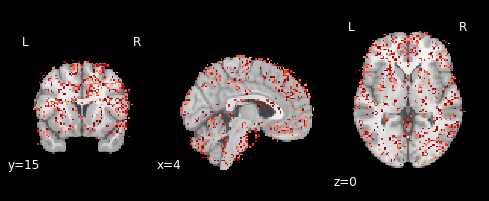

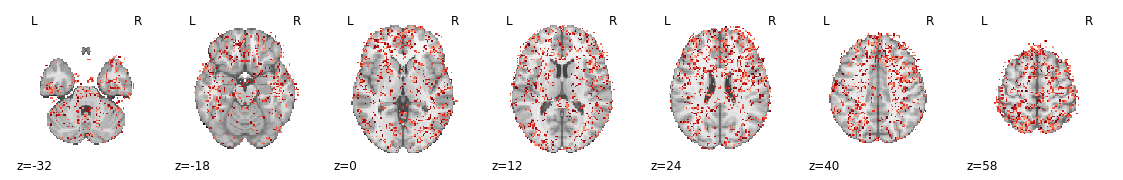

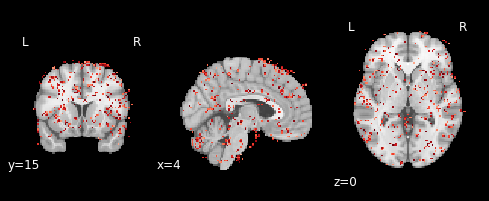

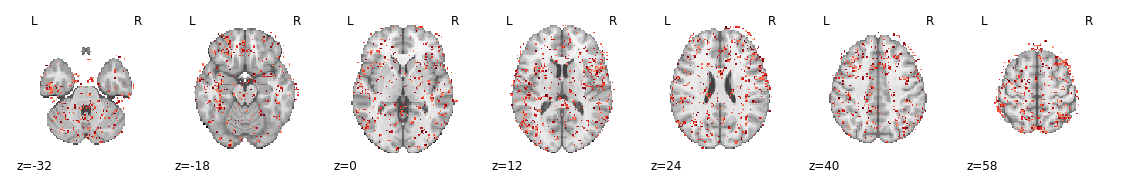

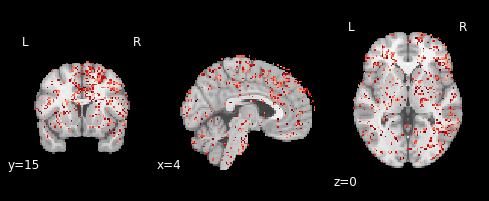

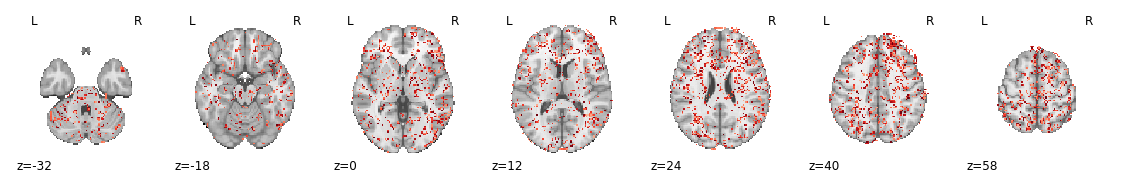

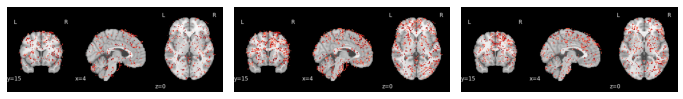

In [6]:
def make_z_ortho_correlated(path_, ext_, out_, cmap_, cut_coord_, z_coords, vmax_, clbar):
    fig = plt.figure(figsize=(15, 8))
    for pair_ in ["fsl-afni", "fsl-spm", "afni-spm"]:
        img_ = '{}{}-{}.nii.gz'.format(path_, ext_, pair_)
        display1 = plotting.plot_img(img_, vmax=vmax_, vmin=2-vmax_ , black_bg=True,
                                     display_mode='ortho', cut_coords=cut_coord_,
                                     colorbar=clbar, threshold=0.5, bg_img='MNI152TEMPLATE',
                                     #norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                     cmap=cmap_,  draw_cross=False)
        display2 = plotting.plot_img(img_, vmax=vmax_, vmin=2-vmax_ , black_bg=False,
                                     display_mode='z', cut_coords=z_coords,
                                     colorbar=clbar, threshold=0.5, bg_img='MNI152TEMPLATE',
                                     #norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                     cmap=cmap_, draw_cross=False)
        
        display1.savefig('{}{}-{}-ortho.png'.format(out_, pair_, ext_)) 
        display2.savefig('{}{}-{}-z.png'.format(out_, pair_, ext_)) 

def make_row_of_tools_corr(path_, pre_, ext_, out_):
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(12, 24))
    plt.subplots_adjust(wspace=.05, top=0.2, hspace=0.0)
    for i, pair_ in enumerate(["fsl-spm", "fsl-afni", "afni-spm"]):
        img_z = '{}{}{}-{}-z.png'.format(path_, pre_, pair_, ext_)
        img_ortho = '{}{}{}-{}-ortho.png'.format(path_, pre_, pair_, ext_)
        img_z = Image.open(img_z)
        img_ortho = Image.open(img_ortho)
        
        #if title == True:
        #    ax[0][i].set_title(pair_.upper(), pad=20)
        ax[i].imshow(img_ortho)
        ax[i].axis('off')
        #ax[1][i].imshow(img_z)
        #ax[1][i].axis('off')

    plt.savefig(out_, bbox_inches='tight', format='png', dpi=600, facecolor='white', transparent=False)

make_z_ortho_correlated('./data/std/clusters/correlated-maps-','unthresh',
                        './paper/figures/plots/correlated-maps-',
                        'Reds', cut_coord_, z_coords, 2, False)

make_row_of_tools_corr('./paper/figures/plots/correlated-maps-', '', 'unthresh', './paper/figures/plots/fin//fin/correlated-maps-unthresh.png')



In [6]:
# Framing images
first_image = Image.open("./paper/figures/std/bg2.png")
second_image = Image.open("./paper/figures/plots/fin/fin/correlated-maps-unthresh.png")
width, height = second_image.size
first_image.paste(second_image.resize((width//4, height//4)), (78,68))
first_image.save("./paper/figures/std/correlated-unthresh.png","PNG")

## Global nearest precision


/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:347: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/home/Ali/Desktop/git_repo/fuzzy-neurotools/venv3/lib/python3.8/site-packages/nilearn/plotting/displays.py:101: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = getattr(ax, type)(data_2d.copy(),


<Figure size 1080x576 with 0 Axes>

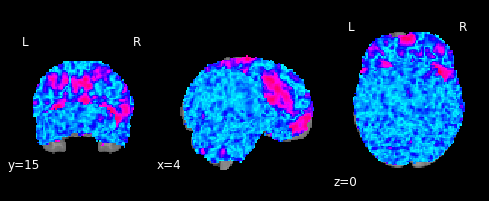

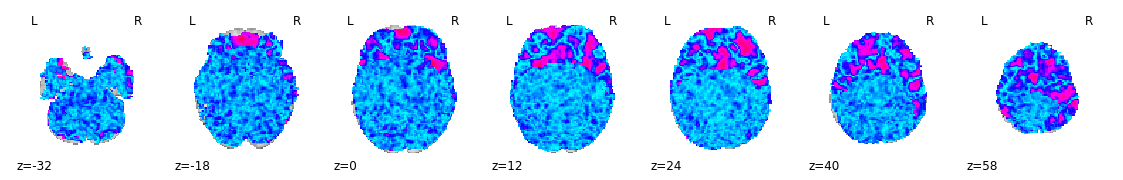

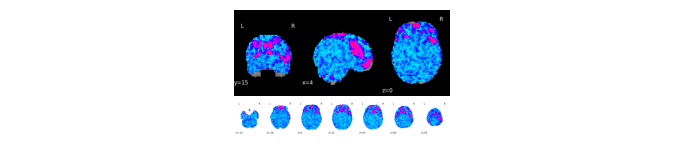

In [3]:
fig = plt.figure(figsize=(15, 8))
vmax_ = 3
cmap_ = 'hsv'
p_min = 17 # global nearest virtual precision

img_ = './data/std/FL-FSL/p{}_fsl_unthresh_std.nii.gz'.format(p_min)
out_ortho = './paper/figures/plots/p{}-wt-unthresh-ortho.png'.format(p_min)
out_z = './paper/figures/plots/p{}-wt-unthresh-z.png'.format(p_min)
display1 = plotting.plot_stat_map(img_,
                                 vmax=vmax_, black_bg=True,display_mode='ortho', colorbar=False,
                                 norm=matplotlib.colors.SymLogNorm(linthresh=1), #title='WT',
                                 cmap=cmap_,cut_coords=cut_coord_, draw_cross=False)
display2 = plotting.plot_stat_map(img_, vmax=vmax_, display_mode='z', cut_coords=z_coords,
                                 norm=matplotlib.colors.SymLogNorm(linthresh=1),
                                 cmap=cmap_,colorbar=clbar, draw_cross=False)
display1.savefig(out_ortho)
display2.savefig(out_z)

# Frame in a row
img_z = Image.open(out_z)
img_ortho = Image.open(out_ortho)

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(12, 24), gridspec_kw={'height_ratios': [2.6, 1]})
plt.subplots_adjust(wspace=.05, top=0.2, hspace=0.0)
for i, pair_ in enumerate(["", "WT FSL", ""]):
    if pair_ != "":
        ax[0][i].imshow(img_ortho)
        ax[1][i].imshow(img_z)
    ax[0][i].axis('off')
    ax[1][i].axis('off')
plt.savefig("./paper/figures/plots/fin/p{}-wt-unthresh.png".format(p_min), bbox_inches='tight', format='png', dpi=600, facecolor='white', transparent=False)


<Figure size 1080x576 with 0 Axes>

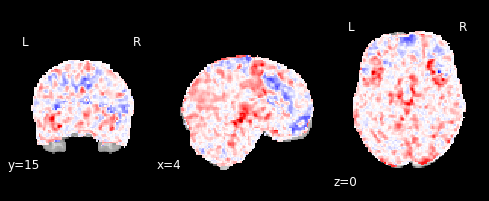

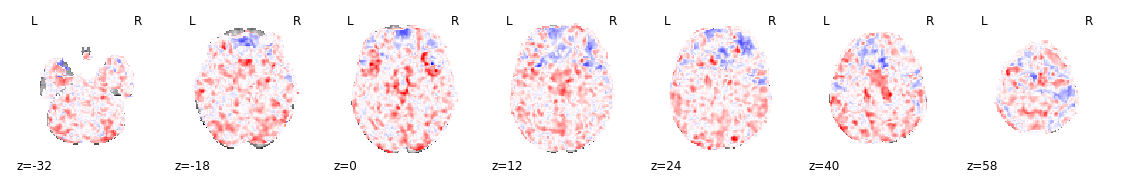

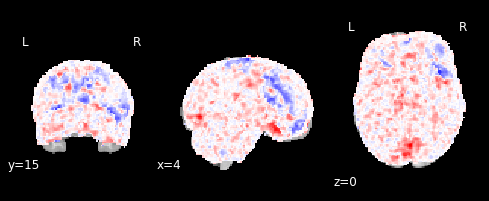

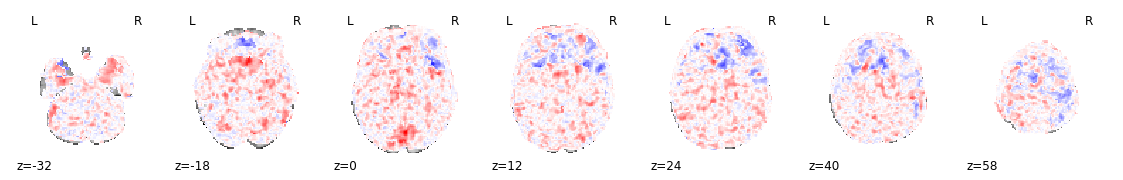

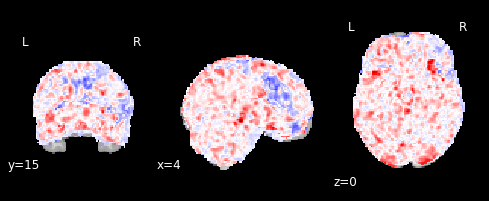

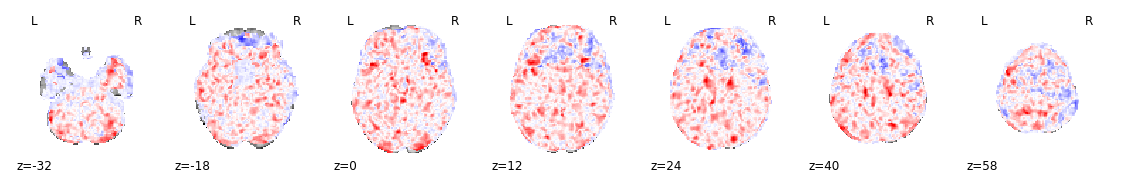

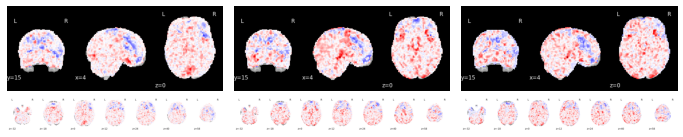

In [10]:
for type_ in ['unthresh']:
    for pair_ in ['fsl-spm', 'fsl-afni', 'afni-spm']:
        img1_ = nib.load('./data/std/{}-{}-std.nii.gz'.format(pair_, type_))
        img2_ = nib.load('./data/std/FL-FSL/p{}_fsl_unthresh_std.nii.gz'.format(p_min))
        if img1_.shape != img2_.shape:
            img1_ = resample_from_to(img1_, img2_, order=0)
        img1_data = np.nan_to_num(img1_.get_fdata())
        img2_data = np.nan_to_num(img2_.get_fdata())
        diff_ = img1_data - img2_data
        nft_img = nib.Nifti1Image(diff_, img1_.affine, header=img1_.header)
        nib.save(nft_img, os.path.join('./data/std/', 'p{}-btMwt-{}-{}.nii.gz'.format(p_min, pair_, type_)))

make_z_ortho_plots('./data/std/p{}-'.format(p_min), 'btMwt-', 'unthresh',
                   './paper/figures/plots/p{}-btMwt-'.format(p_min),
                   'seismic', cut_coord_, z_coords, max_diff, clbar)

make_row_of_tools('./paper/figures/plots/p{}-'.format(p_min), 'btMwt-', 'unthresh',
                  './paper/figures/plots/fin/p{}-btMwt-unthresh.png'.format(p_min))


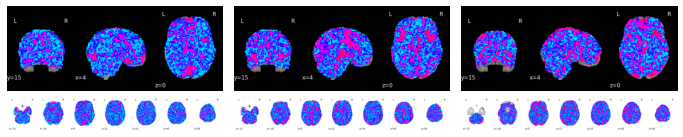

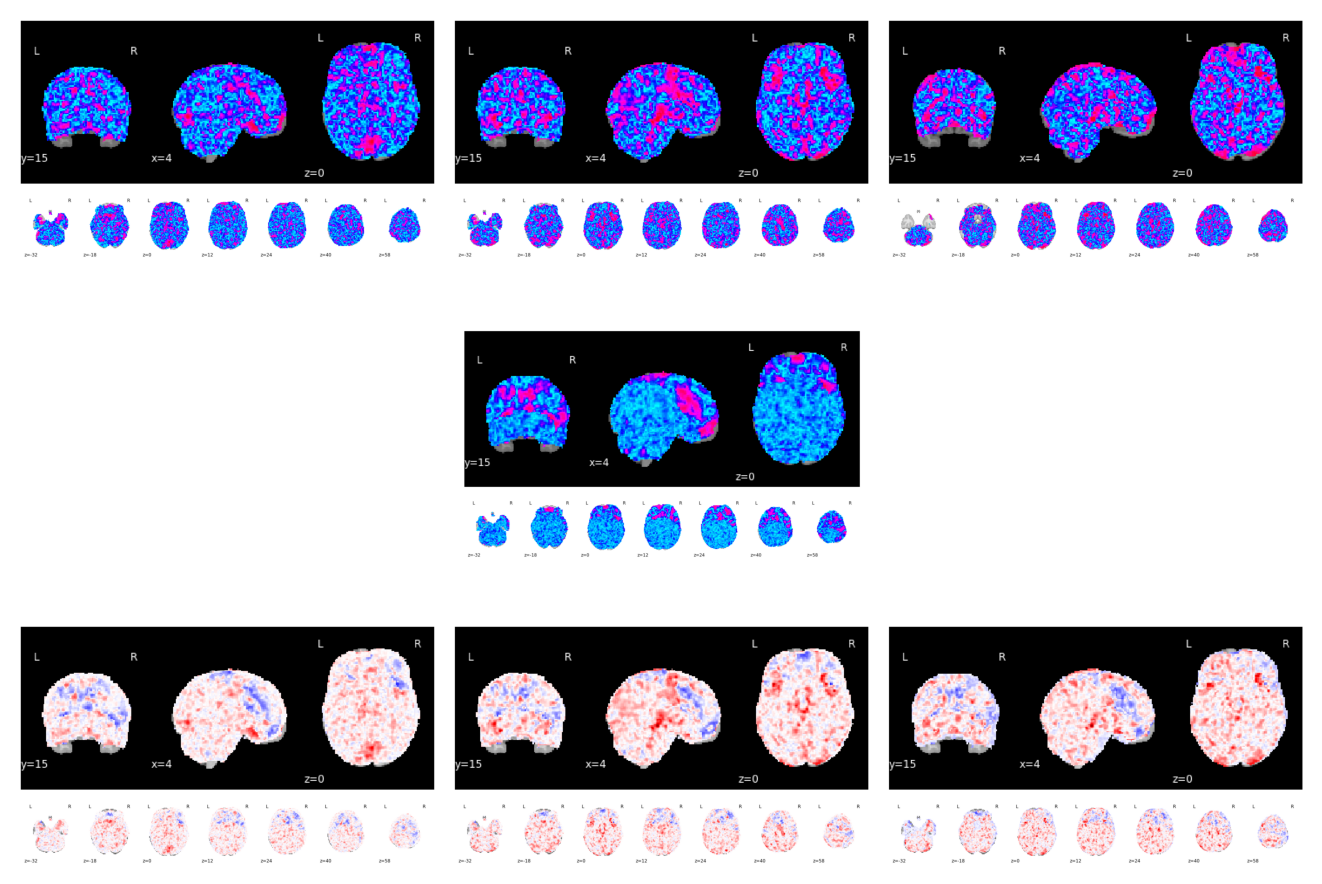

In [11]:
make_row_of_tools('./paper/figures/plots/', '', 'unthresh', './paper/figures/plots/fin/p{}-bt-unthresh.png'.format(p_min))
make_complete_fig('./paper/figures/plots/fin/', 'p{}-'.format(p_min), 'unthresh',
                  './paper/figures/plots/fin/fin/p{}-unthresh.png'.format(p_min), 0.15)


# 